In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [12]:
import warnings

# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [13]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [14]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [15]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

# n_hidden=64 and dropout=0.75

In [16]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 64

import warnings
warnings.filterwarnings("ignore")

# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.75))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

128
9
7352
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 106s 14ms/step - loss: 1.3362 - acc: 0.4219 - val_loss: 1.1777 - val_acc: 0.4425
Epoch 2/30
7352/7352 [==============================] - 85s 12ms/step - loss: 1.0784 - acc: 0.5286 - val_loss: 0.9738 - val_acc: 0.5908
Epoch 3/30
7352/7352 [==============================] - 113s 15ms/step

In [17]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 499       11         0        0                   0   
SITTING                  1      421        67        1                   0   
STANDING                 0      124       402        5                   0   
WALKING                  0        1         0      450                  21   
WALKING_DOWNSTAIRS       0        0         0        0                 403   
WALKING_UPSTAIRS         0        2         0       20                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            1  
STANDING                           1  
WALKING                           24  
WALKING_DOWNSTAIRS                17  
WALKING_UPSTAIRS                 449  


In [18]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 618us/step


In [19]:
score

[0.6202012920251873, 0.8903970139124533]

<IPython.core.display.Javascript object>


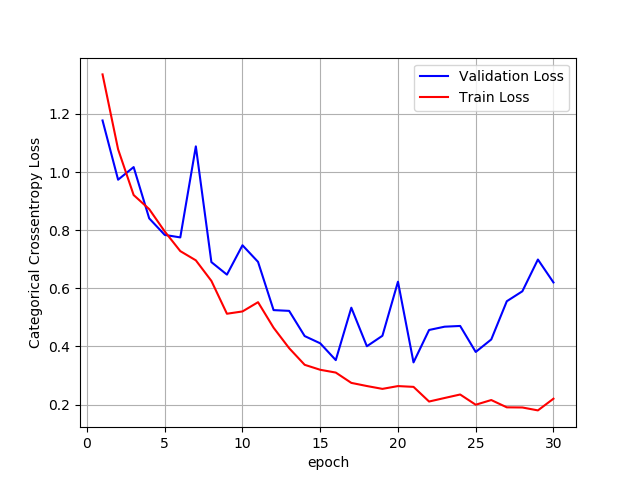

In [21]:
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

%matplotlib notebook
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

- With a simple 2 layer architecture and number of hidden layers=64 , we got 89.03% accuracy and a loss of 0.620

# n_hidden=256 dropout_rate=0.80

In [22]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 256

import warnings
warnings.filterwarnings("ignore")

# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.80))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

128
9
7352
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               272384    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 273,926
Trainable params: 273,926
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 351s 48ms/step - loss: 1.3458 - acc: 0.4320 - val_loss: 1.1183 - val_acc: 0.5640
Epoch 2/30
7352/7352 [==============================] - 435s 59ms/step - loss: 1.2954 - acc: 0.4504 - val_loss: 1.2204 - val_acc: 0.4374
Epoch 3/30
7352/7352 [==============================] - 428s 58ms/s

In [25]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 535        0         0        0                   0   
SITTING                  7      367       116        1                   0   
STANDING                 0       70       460        0                   0   
WALKING                  0        0         0      478                   0   
WALKING_DOWNSTAIRS       0        0         0        0                 396   
WALKING_UPSTAIRS         0        0         0        1                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             2  
SITTING                            0  
STANDING                           2  
WALKING                           18  
WALKING_DOWNSTAIRS                24  
WALKING_UPSTAIRS                 469  


In [26]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 37s 13ms/step


[0.4554048873649215, 0.9178825924669155]

<IPython.core.display.Javascript object>


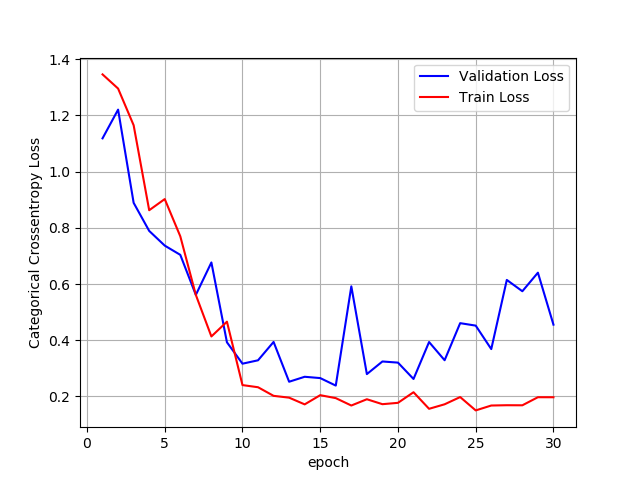

In [27]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

- With a simple 2 layer architecture and number of hidden layers=256 and dropout_rate=0.75 , we got 91.78% accuracy and a loss of 0.45

# 2 LSTM Layers + Larger Dropout

In [29]:
# Initializing parameters
epochs = 30
batch_size = 16
#n_hidden = 32

import warnings
warnings.filterwarnings("ignore")

# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

128
9
7352
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 120,454
Trainable params: 120,454
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 433s 59ms/step - loss: 1.1594 - acc: 0.5226 - val_loss: 1.2993 - val_acc: 0.4462
Epoch 2/30
7352/7352 [==============================] - 410s 56ms/step -

In [30]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))


Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 516        0        21        0                   0   
SITTING                  0      379       112        0                   0   
STANDING                 0       91       441        0                   0   
WALKING                  0        0         0      444                  40   
WALKING_DOWNSTAIRS       0        0         0        4                 410   
WALKING_UPSTAIRS         0        1         5        0                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                           12  
WALKING_DOWNSTAIRS                 6  
WALKING_UPSTAIRS                 462  


In [31]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 27s 9ms/step


[0.44939401513188654, 0.8998982015609094]

Observation: With 2 LSTM Layers and larger dropout , accuracy is 89.98% with loss of 0.449

<IPython.core.display.Javascript object>


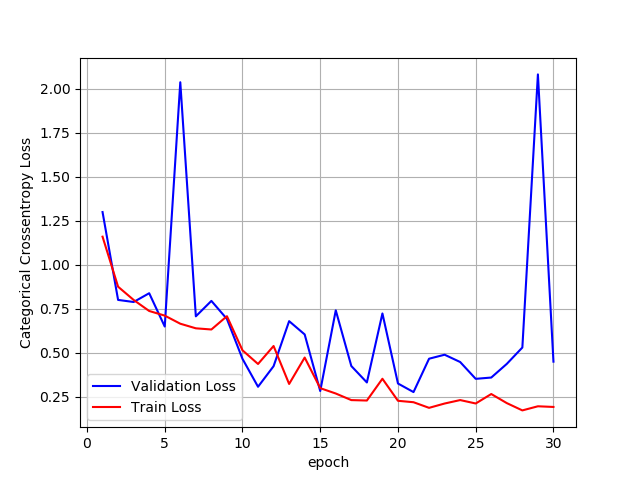

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [40]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Num_hidden_layers", "Dropout_rate", "Loss", "Accuracy"]

x.add_row(["LSTM", 64 , 0.75,0.6202012920251873,0.8903970139124533])
x.add_row(["LSTM", 256, 0.80,0.4554048873649215,0.9178825924669155])
x.add_row(["2-LSTM", "128 and 64",0.8,0.44939401513188654, 0.8998982015609094])
           
print(x)

+--------+-------------------+--------------+---------------------+--------------------+
| Model  | Num_hidden_layers | Dropout_rate |         Loss        |      Accuracy      |
+--------+-------------------+--------------+---------------------+--------------------+
|  LSTM  |         64        |     0.75     |  0.6202012920251873 | 0.8903970139124533 |
|  LSTM  |        256        |     0.8      |  0.4554048873649215 | 0.9178825924669155 |
| 2-LSTM |     128 and 64    |     0.8      | 0.44939401513188654 | 0.8998982015609094 |
+--------+-------------------+--------------+---------------------+--------------------+
